In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
DATA_DIR = r"D:\5th semester\AI sessional\archive\Lung Cancer Dataset"  # Adjust if subfolder name differs
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)


In [4]:
for cls in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(path):
        print(f"{cls:15s} -> {len(os.listdir(path))} images")


adenocarcinoma  -> 337 images
Benign cases    -> 120 images
large cell carcinoma -> 187 images
Normal cases    -> 631 images
squamous cell carcinoma -> 260 images


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 1535 files belonging to 5 classes.
Using 1228 files for training.
Using 1228 files for training.
Found 1535 files belonging to 5 classes.
Using 307 files for validation.
Found 1535 files belonging to 5 classes.
Using 307 files for validation.
Classes: ['Benign cases', 'Normal cases', 'adenocarcinoma', 'large cell carcinoma', 'squamous cell carcinoma']
Classes: ['Benign cases', 'Normal cases', 'adenocarcinoma', 'large cell carcinoma', 'squamous cell carcinoma']


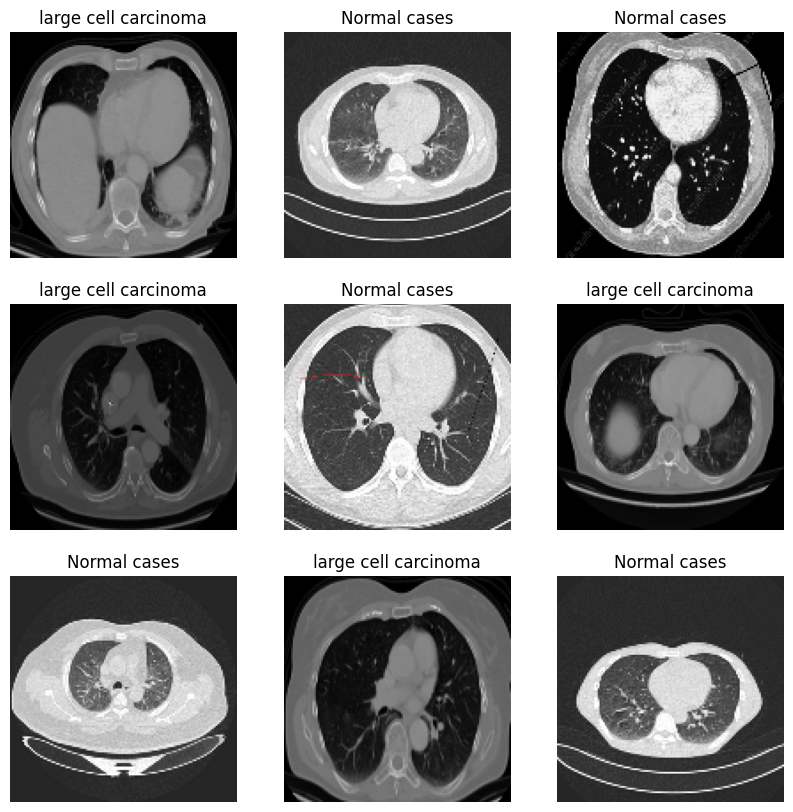

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.06, 0.06)
])


In [7]:
def build_cnn(input_shape=IMG_SIZE+(3,), num_classes=len(class_names)):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    for filters in [32, 64, 128]:
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

model = build_cnn()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,453 (501.77 KB)

 Trainable params: 128,005 (500.02 KB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Quick training run to produce `history` for plotting (1 epoch)
# Compile model if not already compiled, then train for 1 epoch.
if not hasattr(model, 'optimizer'):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=1, verbose=1)
print('Quick training finished.')

39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 536ms/step - accuracy: 0.5765 - loss: 1.0264 - val_accuracy: 0.2052 - val_loss: 1.8767
Quick training finished.
39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 536ms/step - accuracy: 0.5765 - loss: 1.0264 - val_accuracy: 0.2052 - val_loss: 1.8767
Quick training finished.


In [17]:
# --- Train the model (creates `history`)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# NOTE: This will run for EPOCHS epochs; reduce EPOCHS above if you want a faster run.
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
print('Training finished. Last val_accuracy =', history.history.get('val_accuracy', ['n/a'])[-1])

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 510ms/step - accuracy: 0.5977 - loss: 0.9201 - val_accuracy: 0.2117 - val_loss: 2.8453
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 510ms/step - accuracy: 0.5977 - loss: 0.9201 - val_accuracy: 0.2117 - val_loss: 2.8453
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 515ms/step - accuracy: 0.6173 - loss: 0.8416 - val_accuracy: 0.2052 - val_loss: 3.5953
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 515ms/step - accuracy: 0.6173 - loss: 0.8416 - val_accuracy: 0.2052 - val_loss: 3.5953
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.6181 - loss: 0.8273 - val_accuracy: 0.2052 - val_loss: 3.5277
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.6181 - loss: 0.8273 - val_accuracy: 0.2052 - val_loss: 3.5277
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 525ms/step - accuracy: 0.6417 - loss: 0.7967 - val_accuracy: 0.2052 - val_loss: 3.9470
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 525ms/step - accuracy: 0.6417 - loss: 0.7967 - val_accu

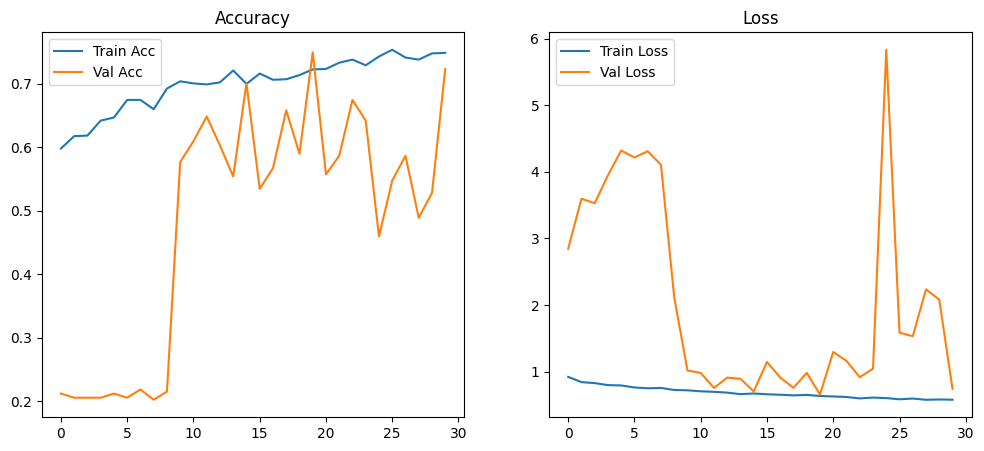

In [18]:
# Plot training history safely: only plot if `history` exists
if 'history' in globals() and hasattr(history, 'history') and history.history:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history.get('accuracy', []), label='Train Acc')
    plt.plot(history.history.get('val_accuracy', []), label='Val Acc')
    plt.legend(); plt.title('Accuracy')
    
    plt.subplot(1,2,2)
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Val Loss')
    plt.legend(); plt.title('Loss')
    plt.show()
else:
    print("No training history found. Run the training cell (after the model) to produce `history` and then re-run this cell.")

In [19]:
# Ensure model is compiled before evaluation and handle result safely
if not hasattr(model, 'optimizer'):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

res = model.evaluate(val_ds, verbose=1)
# res may be a scalar or a list/tuple (loss, metric1, metric2...)
if isinstance(res, (list, tuple)):
    loss = res[0]
    if len(res) > 1:
        acc = res[1]
        print(f"Validation Accuracy: {acc:.4f}")
    else:
        print(f"Validation Loss: {loss:.4f}")
else:
    print("Evaluation result:", res)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7231 - loss: 0.7404
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7231 - loss: 0.7404
Validation Accuracy: 0.7231
Validation Accuracy: 0.7231


In [ ]:
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))


Confusion matrix `cm` not found — computing from model predictions on val_ds...
Computed confusion matrix with shape (5, 5)
Computed confusion matrix with shape (5, 5)


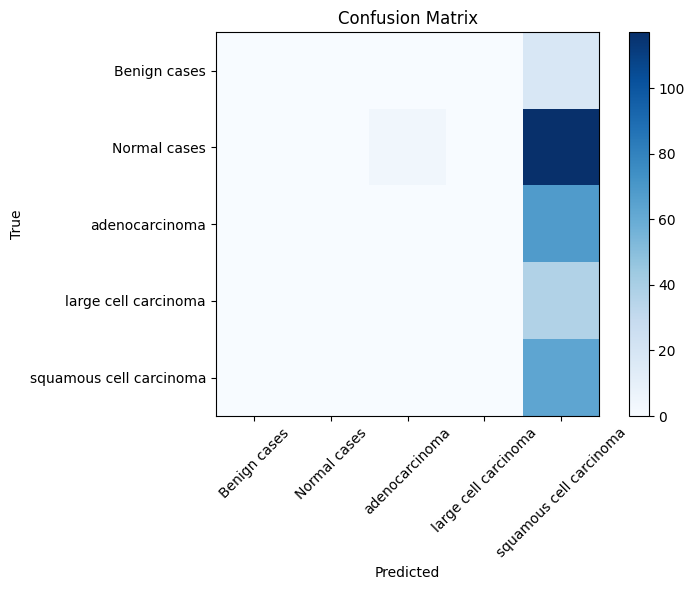

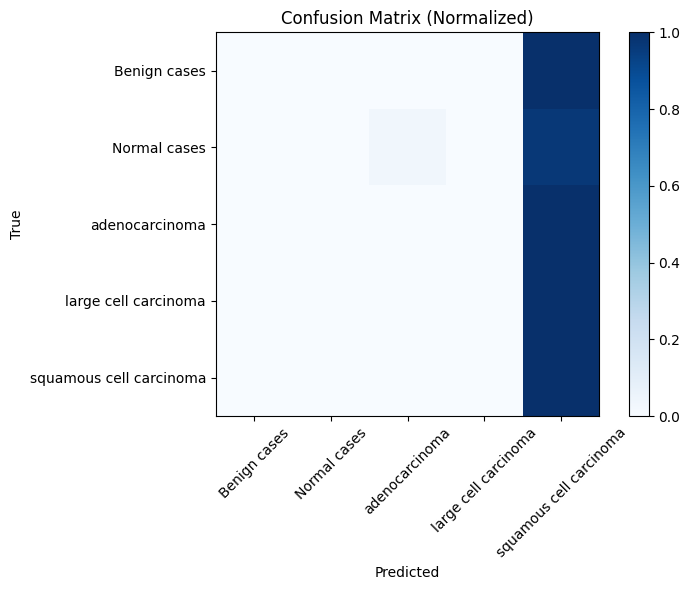

In [9]:
# Plot confusion matrix; compute cm if missing
from sklearn.metrics import confusion_matrix

if 'cm' not in globals() or cm is None:
    print('Confusion matrix `cm` not found — computing from model predictions on val_ds...')
    y_true, y_pred = [], []
    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    cm = confusion_matrix(y_true, y_pred)
    print('Computed confusion matrix with shape', cm.shape)

def plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm_display = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm_display = cm
    plt.figure(figsize=(8,6))
    plt.imshow(cm_display, cmap='Blues')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Plot both raw and normalized
plot_confusion_matrix(cm, class_names)
plot_confusion_matrix(cm, class_names, normalize=True)


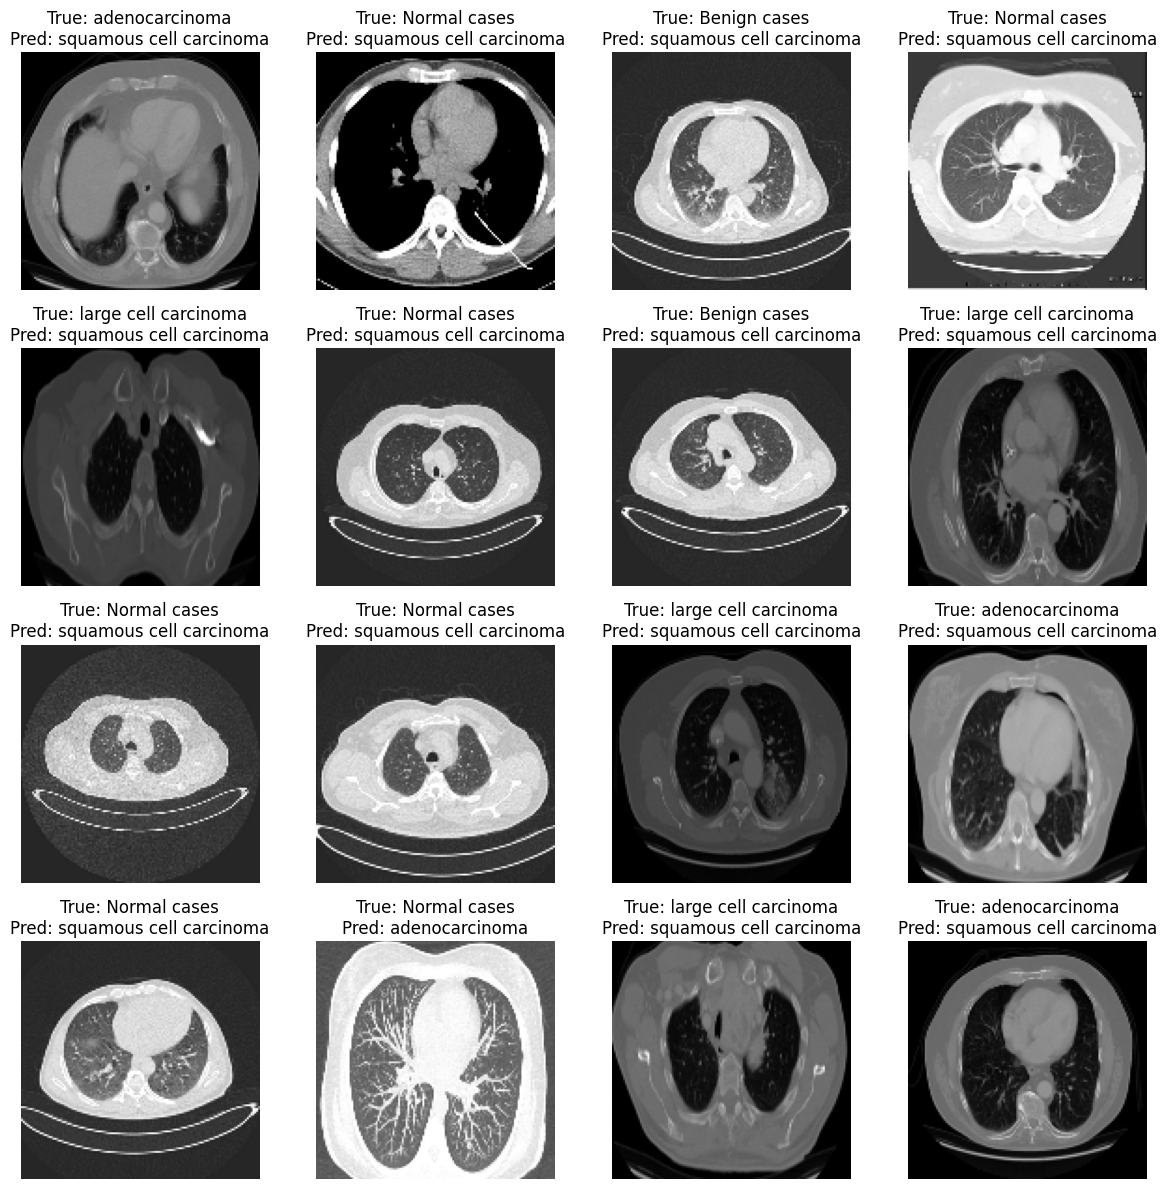

Saved misclassified sample list to misclassified_samples.csv


In [12]:
# Visualize a sample of misclassified images (up to 16)
# Recompute predictions and image list fresh to avoid stale/mismatched indices
images_list = []
y_true = []
y_pred = []
for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    preds_idx = np.argmax(preds, axis=1)
    # store numpy arrays for later plotting
    imgs_np = images.numpy()
    for img, t, p in zip(imgs_np, labels.numpy(), preds_idx):
        images_list.append(img)
        y_true.append(int(t))
        y_pred.append(int(p))

mis_idx = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
if not mis_idx:
    print('No misclassified examples found on the validation set.')
else:
    # ensure indices are within the images_list bounds (they should be)
    mis_idx = [i for i in mis_idx if 0 <= i < len(images_list)]
    if not mis_idx:
        print('No valid misclassified indices after bounds check.')
    else:
        n = min(16, len(mis_idx))
        sample = mis_idx[:n]
        plt.figure(figsize=(12, 12))
        for i, idx in enumerate(sample):
            ax = plt.subplot(4, 4, i + 1)
            img = images_list[idx]
            # convert to uint8 for display if needed
            if img.dtype != 'uint8':
                try:
                    img_disp = img.astype('uint8')
                except Exception:
                    # scale floats in [0,1] to [0,255]
                    img_disp = (np.clip(img, 0, 1) * 255).astype('uint8')
            else:
                img_disp = img
            plt.imshow(img_disp)
            plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Save misclassified list to CSV (safe: overwrite)
try:
    import pandas as pd
    rows = []
    for idx in mis_idx:
        rows.append({
            'index': idx,
            'true_label': class_names[y_true[idx]],
            'pred_label': class_names[y_pred[idx]]
        })
    df_mis = pd.DataFrame(rows)
    df_mis.to_csv('misclassified_samples.csv', index=False)
    print('Saved misclassified sample list to misclassified_samples.csv')
except Exception as e:
    print('Could not save misclassified CSV:', e)

In [10]:
# Export confusion matrix and classification report to CSV files
import pandas as pd
from sklearn.metrics import classification_report

# Ensure y_true and y_pred exist
if 'y_true' not in globals() or 'y_pred' not in globals():
    y_true, y_pred = [], []
    for images, labels in val_ds:
        preds = model.predict(images, verbose=0)
        preds_idx = np.argmax(preds, axis=1)
        for t, p in zip(labels.numpy(), preds_idx):
            y_true.append(int(t))
            y_pred.append(int(p))

# Confusion matrix (cm) should exist; recompute if not
if 'cm' not in globals() or cm is None:
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)

# Save confusion matrix to CSV with class names
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.to_csv('confusion_matrix.csv')
print('Saved confusion_matrix.csv')

# Classification report as DataFrame and CSV
report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report.to_csv('classification_report.csv')
print('Saved classification_report.csv')

# Show a quick preview
print('\nClassification report (sample):')
print(df_report.head())

Saved confusion_matrix.csv
Saved classification_report.csv

Classification report (sample):
                         precision  recall  f1-score  support
Benign cases              0.000000     0.0  0.000000     18.0
Normal cases              0.000000     0.0  0.000000    121.0
adenocarcinoma            0.000000     0.0  0.000000     68.0
large cell carcinoma      0.000000     0.0  0.000000     37.0
squamous cell carcinoma   0.207921     1.0  0.344262     63.0


d:\5th semester\AI sessional\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\5th semester\AI sessional\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\5th semester\AI sessional\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

In [13]:
model.save("lung_cancer_cnn_final.h5")
print("Model saved successfully!")


Model saved successfully!
